[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Trusted-AI/AIF360/blob/master/examples/demo_lfr.ipynb)


#### This notebook demonstrates the use of the learning fair representations algorithm for bias mitigation
Learning fair representations [1] is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes. We will see how to use this algorithm for learning representations that encourage individual fairness and apply them on the Adult dataset.

References:

[1] R. Zemel, Y. Wu, K. Swersky, T. Pitassi, and C. Dwork,  "Learning Fair Representations."
International Conference on Machine Learning, 2013.

In [23]:
!pip install aif360

In [24]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.lfr import LFR

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np

In [25]:
# Metrics function
from collections import OrderedDict

def compute_metrics(dataset_true, dataset_pred,
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()

    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))

    return metrics

In [26]:
import os
import urllib
import aif360

# Obtain the location where it is installed
LIB_PATH = aif360.__file__.rsplit("aif360", 1)[0]

# check if the data got download properly
def check_data_or_download(destn, files, data_source_directory):
    check = all(item in os.listdir(destn) for item in files)
    if check:
        print("Adult dataset is available for us")
    else:
        print("Some files are missing. Downloading now.")
        for data_file in files:
            _ = urllib.request.urlretrieve(data_source_directory + data_file,
                                           os.path.join(destn, data_file))

# Download adult dataset
data_source_directory = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/"
destn = os.path.join(LIB_PATH, "aif360", "data", "raw", "adult")
files = ["adult.data", "adult.test", "adult.names"]

check_data_or_download(destn, files, data_source_directory)

Adult dataset is available for us


#### Load dataset and set options

In [27]:
# Get the dataset and split into train and test
dataset_orig = load_preproc_data_adult()
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

#### Clean up training data

In [28]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes,
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


#### Metric for original training data

In [29]:
# Metric for the original dataset
privileged_groups = [{'sex': 1.0}]
unprivileged_groups = [{'sex': 0.0}]

metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.190862


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.203005


#### Train with and transform the original training data

In [30]:
scale_orig = StandardScaler()
dataset_orig_train.features = scale_orig.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = scale_orig.transform(dataset_orig_test.features)

In [31]:
# Input recontruction quality - Ax
# Fairness constraint - Az
# Output prediction error - Ay

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(dataset_orig_train, maxiter=5000, maxfun=5000)

step: 0, loss: 0.8962825492184127, L_x: 2.5714339164470723,  L_y: 0.620754999471439,  L_z: 0.009192079051133246
step: 250, loss: 0.8480866071999373, L_x: 2.5685650112390204,  L_y: 0.5738304854931037,  L_z: 0.00869981029146582
step: 500, loss: 0.812413520785976, L_x: 2.5559943149989834,  L_y: 0.5435687192438329,  L_z: 0.006622685021122375
step: 750, loss: 0.8068090347952472, L_x: 2.5485767929820033,  L_y: 0.540429587756876,  L_z: 0.005760883870085431
step: 1000, loss: 0.7697788013653353, L_x: 2.4301546591529353,  L_y: 0.5097902430672545,  L_z: 0.008486546191393631
step: 1250, loss: 0.7488916175381501, L_x: 2.319045335882304,  L_y: 0.4899897467945588,  L_z: 0.013498668577680478
step: 1500, loss: 0.7292348172986615, L_x: 2.180622957659463,  L_y: 0.47458348428043823,  L_z: 0.018294518626138442
step: 1750, loss: 0.6732503970062083, L_x: 1.8022392527041993,  L_y: 0.4457481793715224,  L_z: 0.023639146182132982
step: 2000, loss: 0.6551453071296062, L_x: 1.7369379199412447,  L_y: 0.445473465101

In [32]:
# Transform training data and align features
dataset_transf_train = TR.transform(dataset_orig_train)
dataset_transf_test = TR.transform(dataset_orig_test)

In [33]:
print(classification_report(dataset_orig_test.labels, dataset_transf_test.labels))

              precision    recall  f1-score   support

         0.0       0.81      0.95      0.87     11142
         1.0       0.62      0.28      0.39      3511

    accuracy                           0.79     14653
   macro avg       0.72      0.61      0.63     14653
weighted avg       0.76      0.79      0.76     14653



In [34]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())
metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.062725


#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.057548


In [36]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []

class_thresh_arr = np.linspace(0.01, 0.99, 100)

dataset_transf_test_new = dataset_orig_test.copy(deepcopy=True)
dataset_transf_test_new.scores = dataset_transf_test.scores


for thresh in class_thresh_arr:

    fav_inds = dataset_transf_test_new.scores > thresh
    dataset_transf_test_new.labels[fav_inds] = 1.0
    dataset_transf_test_new.labels[~fav_inds] = 0.0

    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_new,
                                      unprivileged_groups, privileged_groups,
                                      disp = False)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

/usr/local/lib/python3.10/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)


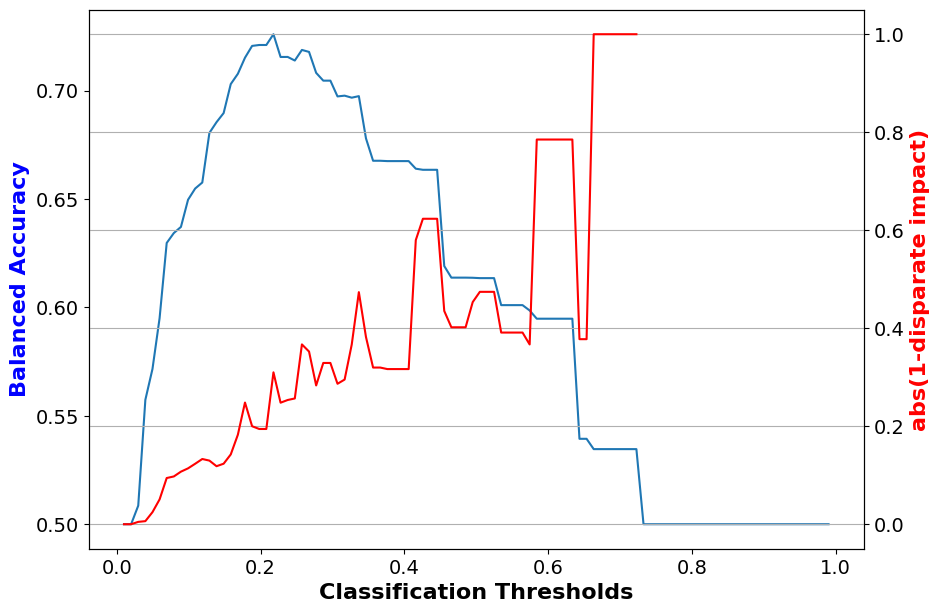

In [37]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

In [38]:
display(Markdown("#### Individual fairness metrics"))
print("Consistency of labels in transformed training dataset= %f" %metric_transf_train.consistency())
print("Consistency of labels in original training dataset= %f" %metric_orig_train.consistency())
print("Consistency of labels in transformed test dataset= %f" %metric_transf_test.consistency())
print("Consistency of labels in original test dataset= %f" %metric_orig_test.consistency())

#### Individual fairness metrics

Consistency of labels in transformed training dataset= 1.000000
Consistency of labels in original training dataset= 0.714183
Consistency of labels in transformed test dataset= 1.000000
Consistency of labels in original test dataset= 0.752337


In [39]:
def check_algorithm_success():
    """Transformed dataset consistency should be greater than original dataset."""
    assert metric_transf_test.consistency() > metric_orig_test.consistency(), "Transformed dataset consistency should be greater than original dataset."

check_algorithm_success()